# Setup + Loading Data

In [1]:
# Make sure that virtual environment is working
import sys
print("Python executable:", sys.executable)

Python executable: /opt/homebrew/Caskroom/miniforge/base/envs/hula-by-reqs/bin/python


In [2]:
# Importing packages
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities_visualization
from process_movella import load_movella, get_position, lowpass_filter
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration, offset_hoop_sensor, estimate_period
from utilities_hula_hoop import plot_time_histories, perform_PCA
from utilities_hula_hoop import plot_PCA, plot_PCA_phase_portait, plot_PCA_eigenvalues, plot_PCA_variance_ratios, plot_Scree, plot_Cumul_Scree
from utilities_hula_hoop import plot_PCA_modes, plot_PCA_modes_3D
from utilities_hula_hoop import fourier_spectrum, plot_FFT, plot_PCA_FFT
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Defining input and output directory

# IN_DIR = Path("/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/Hula Hoop/2025-10-01 Experiment 6/2025-10-01 Euler Angles/")
IN_DIR = Path("uploads/2025-10-01 Experiment 6/2025-10-01 Euler Angles/")
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [4]:
# Constants

# Hoop specifications
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop

# Gravity
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
# dt = 1 / f      # s, sample duration (get this from the data below)

# Inertias in corotational basis
Ixx = 0.5*m*r**2
Iyy = 0.5*m*r**2
Izz = m*r**2

In [5]:
# Reading sensor data

ifile = 3
OR_hoop_file = sorted(list(IN_DIR.glob(f"OR_*.csv")))[ifile]
OL_hoop_file = sorted(list(IN_DIR.glob(f"OL_*.csv")))[ifile]
IT_hoop_file = sorted(list(IN_DIR.glob(f"IT_*.csv")))[ifile]
IL_hoop_file = sorted(list(IN_DIR.glob(f"IL_*.csv")))[ifile]
IB_hoop_file = sorted(list(IN_DIR.glob(f"IB_*.csv")))[ifile]
print(OR_hoop_file)
# print(OL_hoop_file)
# print(IT_hoop_file)
# print(IL_hoop_file)
# print(IB_hoop_file)

lead_time_val = 0
OL_hoop_data = load_movella(OL_hoop_file, lead_time=lead_time_val)
OR_hoop_data = load_movella(OR_hoop_file, lead_time=lead_time_val)
IT_hoop_data = load_movella(IT_hoop_file, lead_time=lead_time_val)
IL_hoop_data = load_movella(IL_hoop_file, lead_time=lead_time_val)
IB_hoop_data = load_movella(IB_hoop_file, lead_time=lead_time_val)

time, OL_ax, OL_ay, OL_az, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz = OL_hoop_data.T
_, OR_ax, OR_ay, OR_az, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz = OR_hoop_data.T
_, IT_ax, IT_ay, IT_az, IT_phi, IT_theta, IT_psi, IT_wx, IT_wy, IT_wz = IT_hoop_data.T
_, IL_ax, IL_ay, IL_az, IL_phi, IL_theta, IL_psi, IL_wx, IL_wy, IL_wz = IL_hoop_data.T
_, IB_ax, IB_ay, IB_az, IB_phi, IB_theta, IB_psi, IB_wx, IB_wy, IB_wz = IB_hoop_data.T

# time step
dt = time[1]-time[0]

uploads/2025-10-01 Experiment 6/2025-10-01 Euler Angles/OR_20251001_221444.csv


In [6]:
# Define the experiment-specific sensor labels and positions

sensor_labels = {
    "OR": "Hoop", 
    "OL": "Waist",
    "IB": "Hip",
    "IT": "Knee",
    "IL": "Ankle"
}
positions = {
    "sensors": { # (X, Y,  Z) position where X is human's right, Y is human's forward, Z is up.
                 # Origin is the ground below the human's centroid.
        "OL":     (15,  0, 102),     # Waist
        "OR":     (15,  0,  96),     # Hoop
        "IB":     (15,  0,  80),     # Hip 
        "IT":     (15,  0,  42),     # Knee
        "IL":     (15,  0,   7)      # Ankle
    },
    "joints": {
        "femur":         (15,  0,  63),     # Femur
        "tibia":         (15,  0,  26),     # Tibia
        "cuneiform":     (15, 10,   5)      # Cuneiform
    }
}

# Examining raw data

### angles: psi, theta, phi

In [7]:
data_dict_angles = {
    'OR': {'psi': OR_psi, 'theta': OR_theta, 'phi': OR_phi},
    'OL': {'psi': OL_psi, 'theta': OL_theta, 'phi': OL_phi},
    'IT': {'psi': IT_psi, 'theta': IT_theta, 'phi': IT_phi},
    'IL': {'psi': IL_psi, 'theta': IL_theta, 'phi': IL_phi},
    'IB': {'psi': IB_psi, 'theta': IB_theta, 'phi': IB_phi},
}
plot_time_histories(sensor_labels, data_dict_angles, time, title="Raw Euler Angle Data")

### angular velocities: wx, wy, wz

In [8]:
data_dict_veloc = {
    'OR': {'wx': OR_wx, 'wy': OR_wy, 'wz': OR_wz}, 
    'OL': {'wx': OL_wx, 'wy': OL_wy, 'wz': OL_wz}, 
    'IT': {'wx': IT_wx, 'wy': IT_wy, 'wz': IT_wz}, 
    'IL': {'wx': IL_wx, 'wy': IL_wy, 'wz': IL_wz}, 
    'IB': {'wx': IB_wx, 'wy': IB_wy, 'wz': IB_wz}, 
} 
y_limits_veloc = {
    'OR': [-10, 5],
    'OL': [-5, 5],
    'IT': [-5, 5],
    'IL': [-5, 5],
    'IB': [-5, 5],
}
plot_time_histories(sensor_labels, data_dict_veloc, time, title="Raw Angular Velocities", y_limits=y_limits_veloc)

### raw accelerations: ax, ay, az

In [9]:
data_dict_acc = {
    'OR': {'ax': OR_ax, 'ay': OR_ay, 'az': OR_az},
    'OL': {'ax': OL_ax, 'ay': OL_ay, 'az': OL_az},
    'IT': {'ax': IT_ax, 'ay': IT_ay, 'az': IT_az},
    'IL': {'ax': IL_ax, 'ay': IL_ay, 'az': IL_az},
    'IB': {'ax': IB_ax, 'ay': IB_ay, 'az': IB_az},
}
y_limits_acc = {
    'OR': [-100, 100],
    'OL': [-10, 10],
    'IT': [-10, 10],
    'IL': [-10, 10],
    'IB': [-10, 10],
}
plot_time_histories(sensor_labels, data_dict_acc, time, title="Raw Accelerations", y_limits=y_limits_acc)

# Finding interval of steady hula hooping

We can detect when steady hula hoop motion is happening by looking at the psi-dot time series. psi is almost constant during steady hula hooping. You see how initially the hula hooper turns the hoop opposite to the directions at which it will rotate, then gives a high initial angular velocity. The initial angular velocity psidot will be sustained by the hoop until failure.

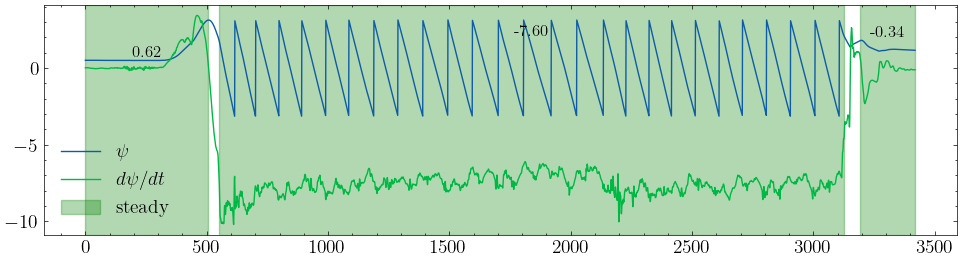

In [10]:
OR_groups, OR_averages = get_steady_hooping_interval(OR_psi, dt=dt, threshold=0.8)

In [11]:
OR_groups

[(np.int64(0), np.int64(505)),
 (np.int64(550), np.int64(3126)),
 (np.int64(3193), np.int64(3419))]

In [12]:
OR_averages

[np.float64(0.6215030127979285),
 np.float64(-7.599026235090466),
 np.float64(-0.33563708811920384)]

In [13]:
# active_slice = np.arange(600, 3000)
active_slice = np.arange(1000, 2000)

In [14]:
plot_time_histories(sensor_labels, data_dict_veloc, time, title="Raw Angular Velocities", y_limits=y_limits_veloc, active_slice=active_slice)

# PCA on displacements, without hoop

## without hoop

Quantities: ['IB:dx', 'IB:dy', 'IB:dz', 'IT:dx', 'IT:dy', 'IT:dz', 'IL:dx', 'IL:dy', 'IL:dz']
shape(X): (1000, 9)
Eigenvalues:
[4.38255648 2.94253749 0.67587587 0.39560208 0.31014578 0.14321956
 0.07777016 0.05495326 0.02634833]
Explained Variance Ratio:
[0.48646377 0.32662166 0.07502222 0.04391183 0.03442618 0.01589737
 0.00863249 0.00609981 0.00292466]


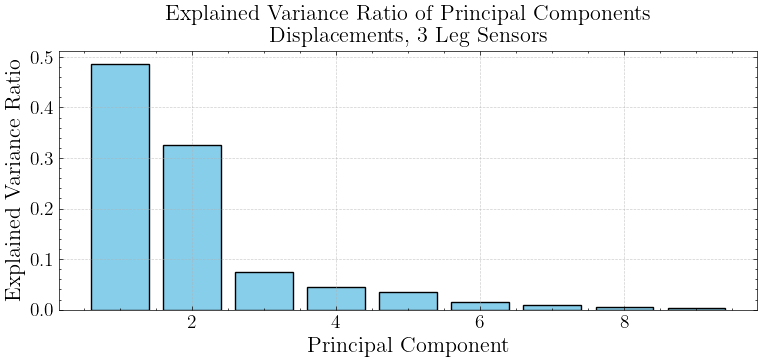

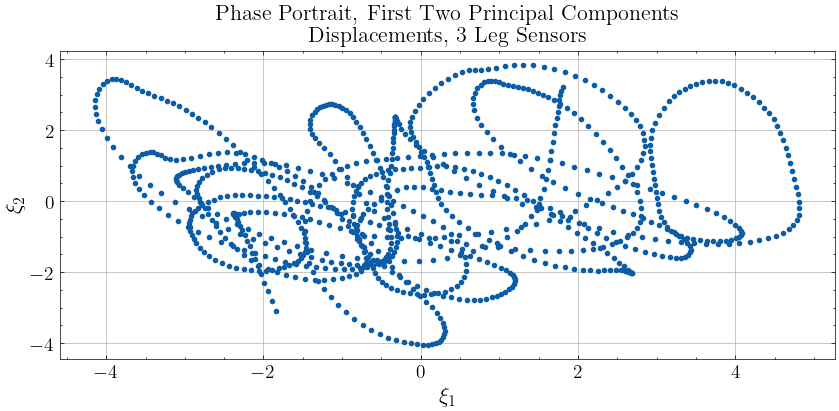

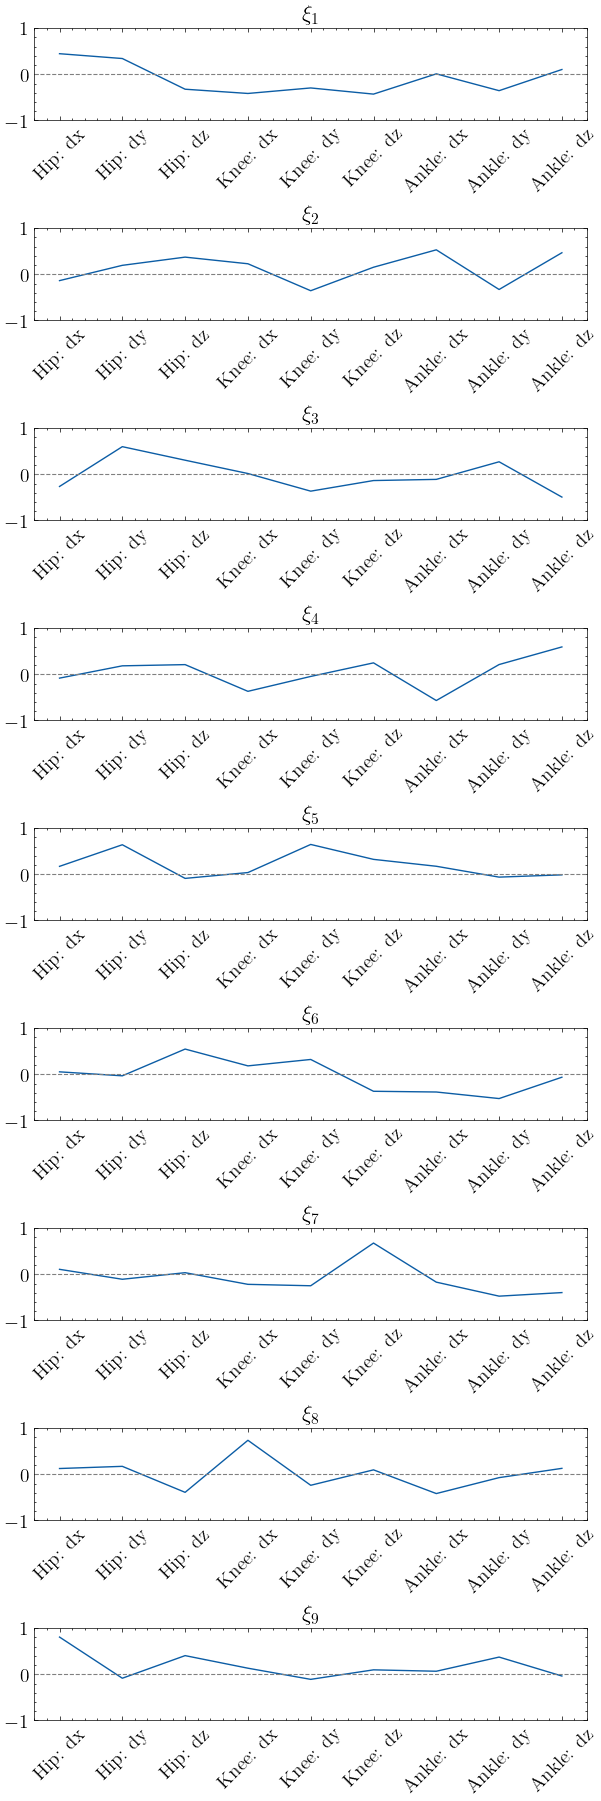

In [15]:
OR_Ax, OR_Ay, OR_Az = get_fixed_frame_acceleration(OR_ax, OR_ay, OR_az, OR_psi, OR_theta, OR_phi)
OL_Ax, OL_Ay, OL_Az = get_fixed_frame_acceleration(OL_ax, OL_ay, OL_az, OL_psi, OL_theta, OL_phi)
IT_Ax, IT_Ay, IT_Az = get_fixed_frame_acceleration(IT_ax, IT_ay, IT_az, IT_psi, IT_theta, IT_phi)
IL_Ax, IL_Ay, IL_Az = get_fixed_frame_acceleration(IL_ax, IL_ay, IL_az, IL_psi, IL_theta, IL_phi)
IB_Ax, IB_Ay, IB_Az = get_fixed_frame_acceleration(IB_ax, IB_ay, IB_az, IB_psi, IB_theta, IB_phi)

OR_dx, OR_dy, OR_dz, OR_vx, OR_vy, OR_vz = get_position(time[active_slice],OR_Ax[active_slice], OR_Ay[active_slice], OR_Az[active_slice], degree=5, initial=0)
OL_dx, OL_dy, OL_dz, OL_vx, OL_vy, OL_vz = get_position(time[active_slice],OL_Ax[active_slice], OL_Ay[active_slice], OL_Az[active_slice], degree=5, initial=0)
IT_dx, IT_dy, IT_dz, IT_vx, IT_vy, IT_vz = get_position(time[active_slice],IT_Ax[active_slice], IT_Ay[active_slice], IT_Az[active_slice], degree=5, initial=0)
IB_dx, IB_dy, IB_dz, IB_vx, IB_vy, IB_vz = get_position(time[active_slice],IB_Ax[active_slice], IB_Ay[active_slice], IB_Az[active_slice], degree=5, initial=0)
IL_dx, IL_dy, IL_dz, IL_vx, IL_vy, IL_vz = get_position(time[active_slice],IL_Ax[active_slice], IL_Ay[active_slice], IL_Az[active_slice], degree=5, initial=0)

data_dict_displ = {
    'OR': {'dx': OR_dx, 'dy': OR_dy, 'dz': OR_dz},
    'OL': {'dx': OL_dx, 'dy': OL_dy, 'dz': OL_dz},
    'IT': {'dx': IT_dx, 'dy': IT_dy, 'dz': IT_dz},
    'IL': {'dx': IL_dx, 'dy': IL_dy, 'dz': IL_dz},
    'IB': {'dx': IB_dx, 'dy': IB_dy, 'dz': IB_dz},
}

sensors_to_include = ["IB","IT","IL"]
quantities_to_include = ["dx","dy","dz"]
subtitle_displ = "Displacements, 3 Leg Sensors"

X_pca, eigenvalues, eigenvectors, explained_variance_ratio = perform_PCA(data_dict_displ,None,
                                                                         sensors_to_include,quantities_to_include,
                                                                         verbose=1) # set verbose=2 for PCA values and eigenvectors
# plot_PCA(X_pca,time[active_slice],None,subtitle_displ)
# plot_PCA_eigenvalues(eigenvalues,subtitle_displ) # Same as variance ratio plot but with eigenvalue values
plot_PCA_variance_ratios(explained_variance_ratio,subtitle_displ)
# plot_Scree(explained_variance_ratio,subtitle_displ) # Same as variance ratio plot but line
# plot_Cumul_Scree(explained_variance_ratio,subtitle_displ)
plot_PCA_phase_portait(X_pca,subtitle_displ)
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,9)

## with hoop

Quantities: ['IB:dx', 'IB:dy', 'IB:dz', 'IT:dx', 'IT:dy', 'IT:dz', 'IL:dx', 'IL:dy', 'IL:dz', 'OL:dx', 'OL:dy', 'OL:dz', 'OR:dx', 'OR:dy', 'OR:dz']
shape(X): (1000, 15)
Eigenvalues:
[5.55844722 3.63359456 1.54547704 0.99618868 0.83069627 0.72584963
 0.62382813 0.33629139 0.3015744  0.23451042 0.10501647 0.05815623
 0.03004575 0.0233424  0.01199642]
Explained Variance Ratio:
[0.37019258 0.2419974  0.10292877 0.06634617 0.05532437 0.04834159
 0.04154695 0.02239701 0.02008486 0.01561839 0.0069941  0.00387321
 0.00200105 0.0015546  0.00079896]


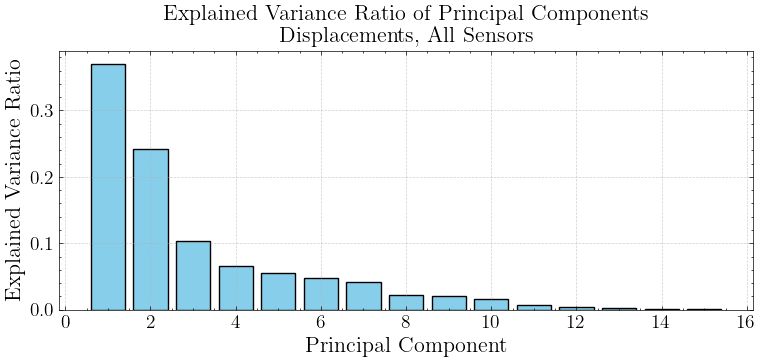

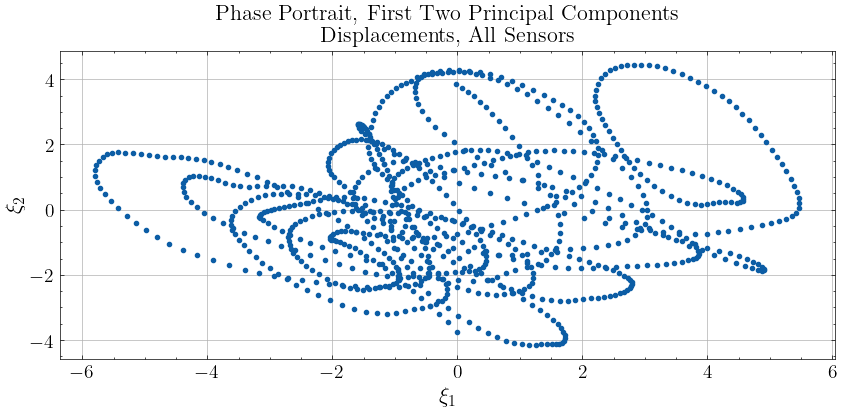

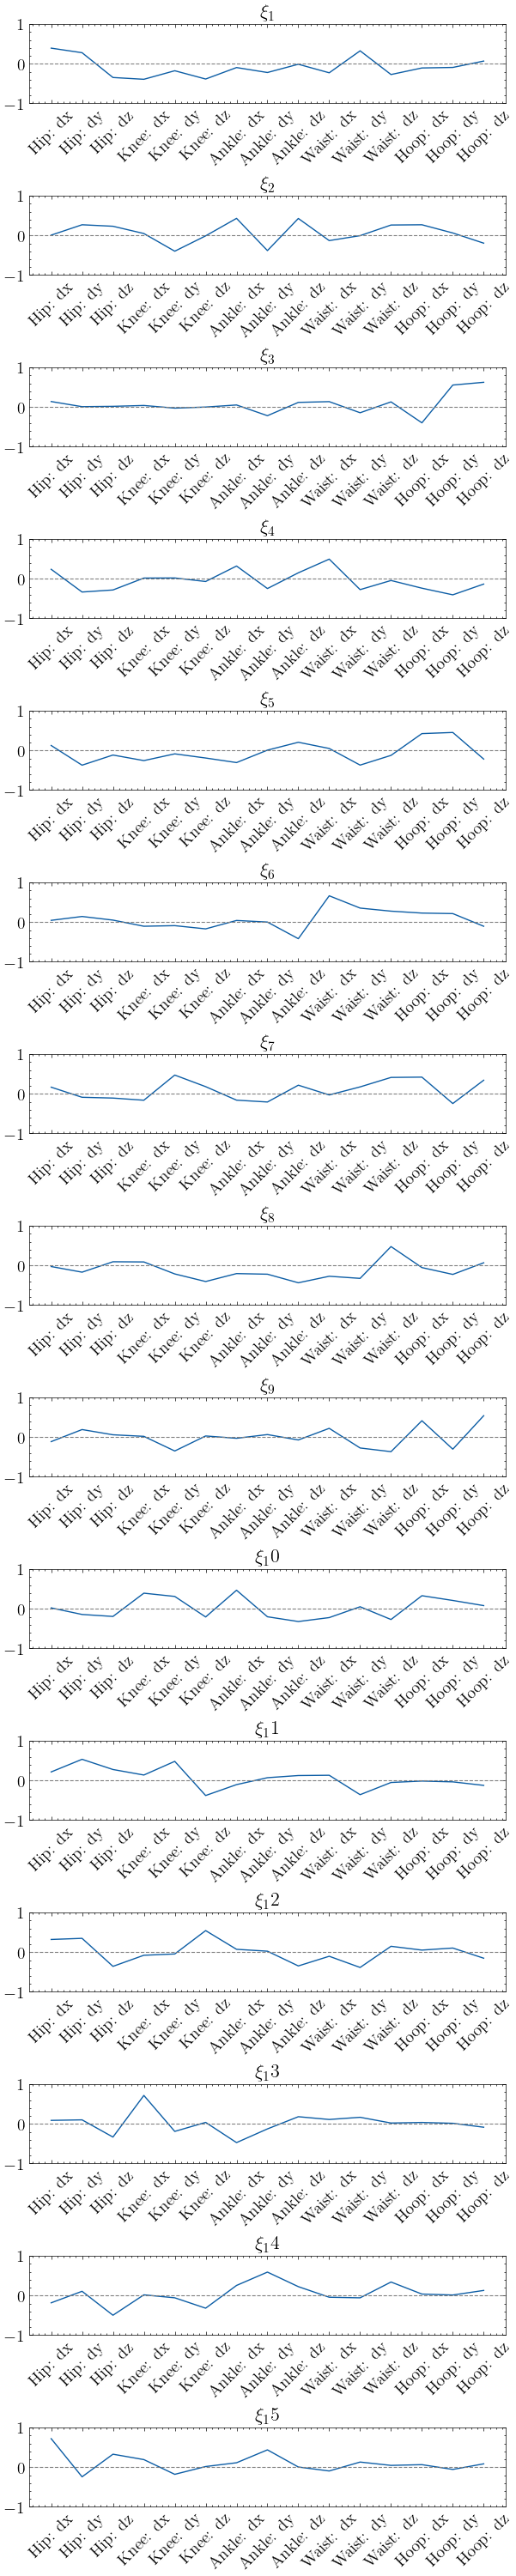

In [16]:
OR_Ax, OR_Ay, OR_Az = get_fixed_frame_acceleration(OR_ax, OR_ay, OR_az, OR_psi, OR_theta, OR_phi)
OL_Ax, OL_Ay, OL_Az = get_fixed_frame_acceleration(OL_ax, OL_ay, OL_az, OL_psi, OL_theta, OL_phi)
IT_Ax, IT_Ay, IT_Az = get_fixed_frame_acceleration(IT_ax, IT_ay, IT_az, IT_psi, IT_theta, IT_phi)
IL_Ax, IL_Ay, IL_Az = get_fixed_frame_acceleration(IL_ax, IL_ay, IL_az, IL_psi, IL_theta, IL_phi)
IB_Ax, IB_Ay, IB_Az = get_fixed_frame_acceleration(IB_ax, IB_ay, IB_az, IB_psi, IB_theta, IB_phi)

OR_dx, OR_dy, OR_dz, OR_vx, OR_vy, OR_vz = get_position(time[active_slice],OR_Ax[active_slice], OR_Ay[active_slice], OR_Az[active_slice], degree=5, initial=0)
OL_dx, OL_dy, OL_dz, OL_vx, OL_vy, OL_vz = get_position(time[active_slice],OL_Ax[active_slice], OL_Ay[active_slice], OL_Az[active_slice], degree=5, initial=0)
IT_dx, IT_dy, IT_dz, IT_vx, IT_vy, IT_vz = get_position(time[active_slice],IT_Ax[active_slice], IT_Ay[active_slice], IT_Az[active_slice], degree=5, initial=0)
IB_dx, IB_dy, IB_dz, IB_vx, IB_vy, IB_vz = get_position(time[active_slice],IB_Ax[active_slice], IB_Ay[active_slice], IB_Az[active_slice], degree=5, initial=0)
IL_dx, IL_dy, IL_dz, IL_vx, IL_vy, IL_vz = get_position(time[active_slice],IL_Ax[active_slice], IL_Ay[active_slice], IL_Az[active_slice], degree=5, initial=0)

data_dict_displ = {
    'OR': {'dx': OR_dx, 'dy': OR_dy, 'dz': OR_dz},
    'OL': {'dx': OL_dx, 'dy': OL_dy, 'dz': OL_dz},
    'IT': {'dx': IT_dx, 'dy': IT_dy, 'dz': IT_dz},
    'IL': {'dx': IL_dx, 'dy': IL_dy, 'dz': IL_dz},
    'IB': {'dx': IB_dx, 'dy': IB_dy, 'dz': IB_dz},
}

sensors_to_include = ["IB","IT","IL","OL","OR"]
quantities_to_include = ["dx","dy","dz"]
subtitle_displ_all = "Displacements, All Sensors"

X_pca, eigenvalues, eigenvectors, explained_variance_ratio = perform_PCA(data_dict_displ,None,
                                                                         sensors_to_include,quantities_to_include,
                                                                         verbose=1) # set verbose=2 for PCA values and eigenvectors
plot_PCA_variance_ratios(explained_variance_ratio,subtitle_displ_all)
plot_PCA_phase_portait(X_pca,subtitle_displ_all)
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,15)

# PCA on angular velocities
Reproducing the results from 'Coordination modes in the multisegmental dynamics of hula hooping' by Balasubramanian and Turvey published in 2004.

Main results
- Karhunen-Loeve decomposition was applied to the kinematics of the lower limbs
- Kinematic variance was accomodated by two modes whose relative contributions varied with task paramters.

Which data should we run into PCA: raw or smooth?

## without hoop

Quantities: ['IB:wx', 'IB:wy', 'IB:wz', 'IT:wx', 'IT:wy', 'IT:wz', 'IL:wx', 'IL:wy', 'IL:wz']
shape(X): (1000, 9)
Eigenvalues:
[3.08798427 2.67403432 1.26523253 0.95938222 0.4207668  0.30809623
 0.15612282 0.08321042 0.0541794 ]
Explained Variance Ratio:
[0.34276625 0.29681781 0.14044081 0.10649143 0.04670511 0.03419868
 0.01732963 0.00923636 0.00601391]


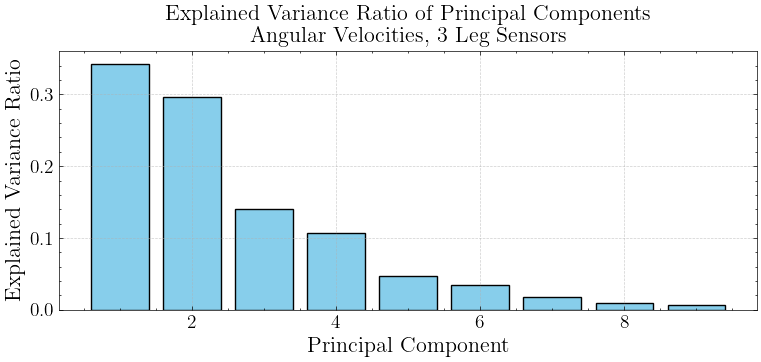

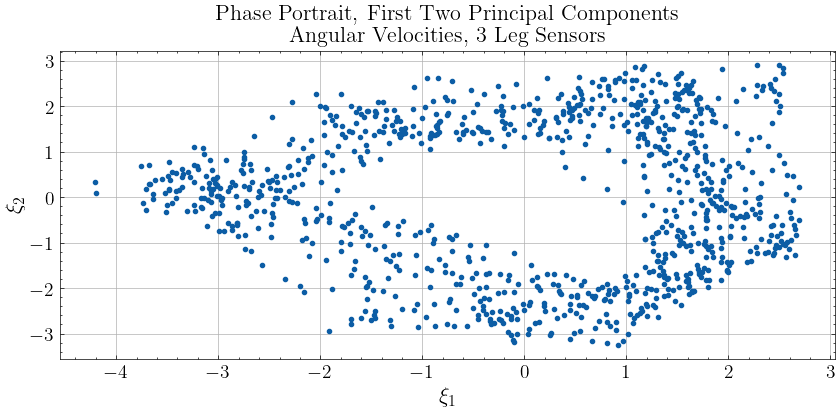

In [17]:
sensors_to_include = ["IB","IT","IL"]
quantities_to_include = ["wx","wy","wz"]
subtitle_veloc = "Angular Velocities, 3 Leg Sensors"

X_pca, eigenvalues, eigenvectors, explained_variance_ratio = perform_PCA(data_dict_veloc,active_slice,
                                                                         sensors_to_include,quantities_to_include,
                                                                         verbose=1) # set verbose=2 for PCA values and eigenvectors
# plot_PCA(X_pca,time,active_slice,subtitle_veloc)
# plot_PCA_eigenvalues(eigenvalues,subtitle_veloc) # Same as variance ratio plot but with eigenvalue values
plot_PCA_variance_ratios(explained_variance_ratio,subtitle_veloc)
# plot_Scree(explained_variance_ratio,subtitle_veloc) # Same as variance ratio plot but line
# plot_Cumul_Scree(explained_variance_ratio,subtitle_veloc)
plot_PCA_phase_portait(X_pca,subtitle_veloc)

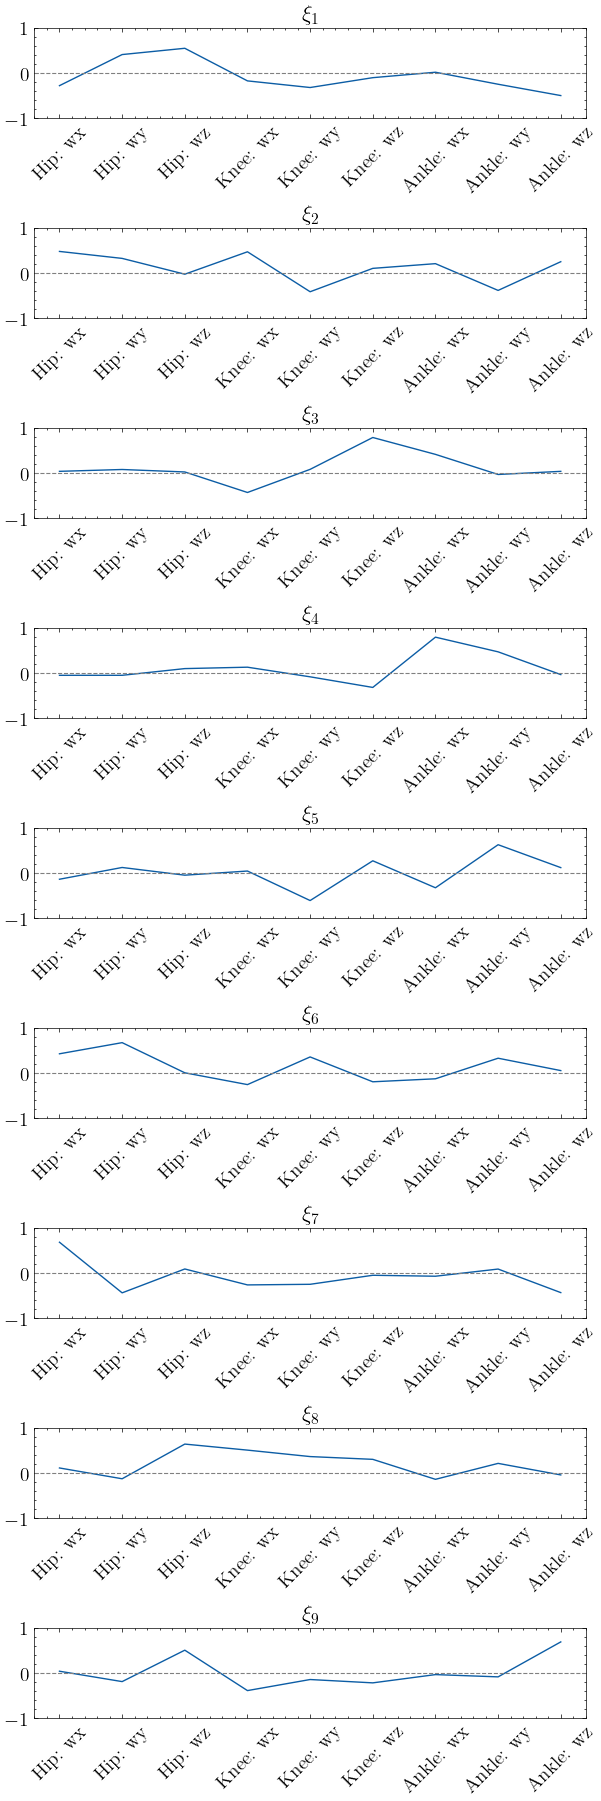

In [18]:
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,9)

freq_psd =['1.680', '1.680', '3.360', '1.800', '1.800', '3.480', '1.320', '0.600', '1.800']
freq_srim=['1.676', '1.671', '3.401', '2.040', '2.126', '3.410', '3.316', '1.077', '2.081']


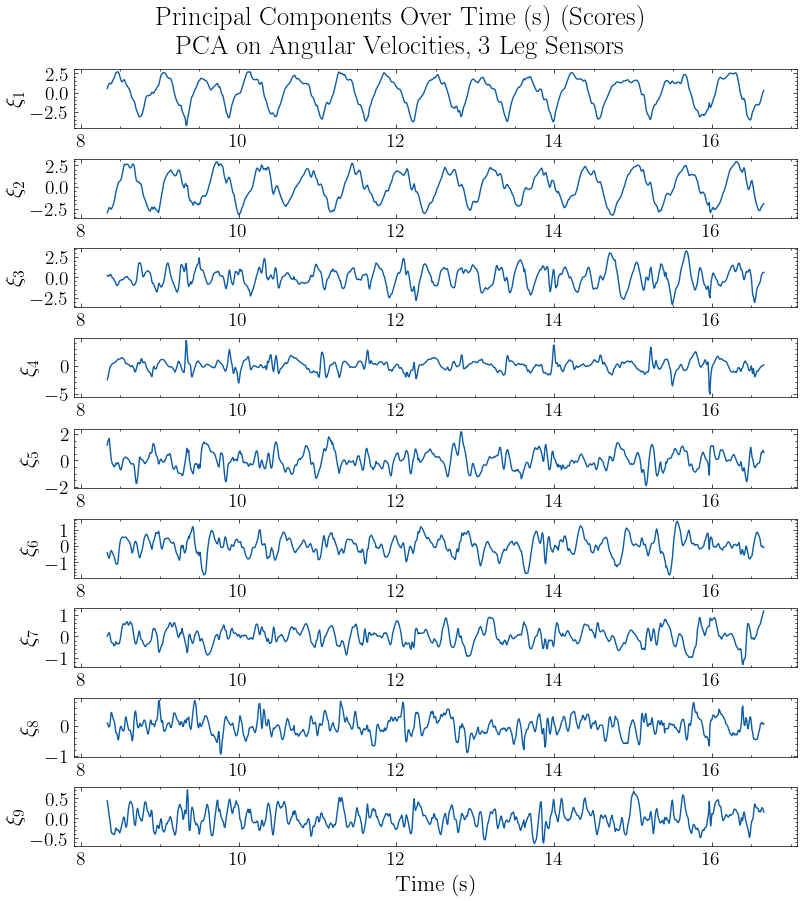

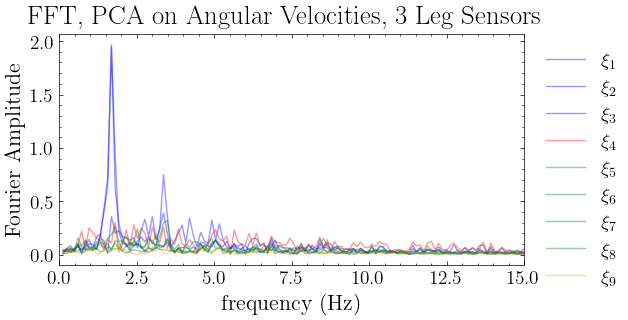

In [19]:
# See that several PCA modes have the same natural frequencies
# freq_fft  = [f"{1/estimate_period(X_pca[:,i], method='fft',  plot=False):.3f}" for i in range(X_pca.shape[1])] # should be the same as PSD (power spectral density)
freq_psd  = [f"{1/estimate_period(X_pca[:,i], method='psd',  plot=False):.3f}" for i in range(X_pca.shape[1])]
freq_srim = [f"{1/estimate_period(X_pca[:,i], method='srim', plot=False):.3f}" for i in range(X_pca.shape[1])]
print(f"{freq_psd =}")
print(f"{freq_srim=}")

plot_PCA(X_pca,time,active_slice,subtitle="PCA on "+subtitle_veloc,separate=True)

# Plot the first four FFT
colors = ['b','b','b','r','g','g','g','g','orange']
plot_PCA_FFT(X_pca,dt,"PCA on "+subtitle_veloc,n_modes=9,xlim=(0,15),colors=colors)

Read `Daffertshofer et al. PCA in studying coordination and variability: a tutorial` figures 7 and 4. According to these authors, the similar periods could be hinting at oscillations under holonomic constraints. That is, the signals might be functionally related (eg. deffering by a phase) rather than totally independent.

PCA might not be the best method to analyze constrained systems: [see what ChatGPT says about this](https://chatgpt.com/share/688979e2-0ef0-8011-97f9-e46adb3f0616)

Other techniques: 
- Constrained Principal Component Analysis: not very well suited. Read more.
- Network Analysis: https://scholar.google.com/citations?user=_VF_KCQAAAAJ&hl=en&oi=ao

## with hoop

Quantities: ['IB:wx', 'IB:wy', 'IB:wz', 'IT:wx', 'IT:wy', 'IT:wz', 'IL:wx', 'IL:wy', 'IL:wz', 'OL:wx', 'OL:wy', 'OL:wz', 'OR:wx', 'OR:wy', 'OR:wz']
shape(X): (1000, 15)
Eigenvalues:
[3.94245848 3.01362467 1.4164318  1.27706553 0.99812892 0.98882873
 0.93329681 0.7601705  0.43196403 0.41738036 0.30045325 0.26587959
 0.13522778 0.08075745 0.05334711]
Explained Variance Ratio:
[0.26256773 0.2007074  0.09433436 0.08505256 0.06647539 0.06585599
 0.06215757 0.05062736 0.0287688  0.02779753 0.02001019 0.01770758
 0.00900617 0.00537845 0.00355292]


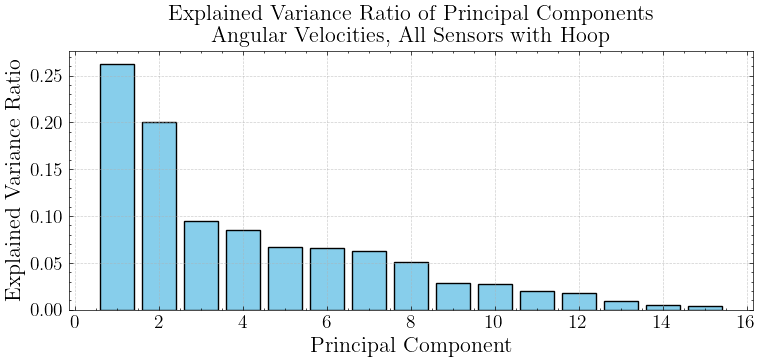

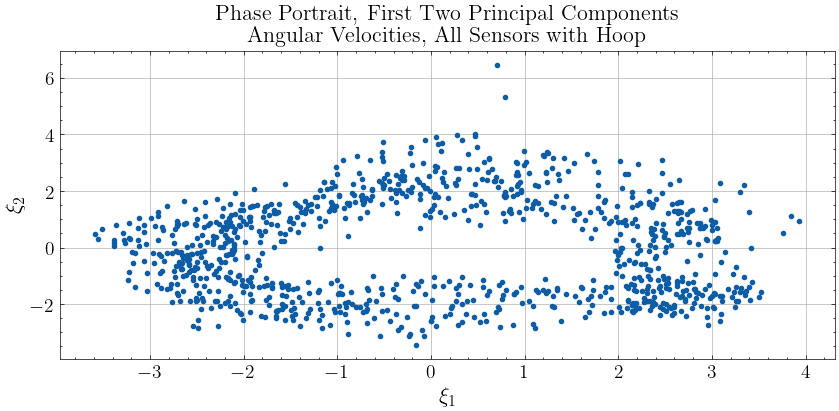

freq_psd =['1.680', '1.680', '0.480', '3.360', '3.000', '0.480', '6.360', '8.880', '0.480', '1.800', '3.480', '3.360', '1.320', '0.600', '1.800']


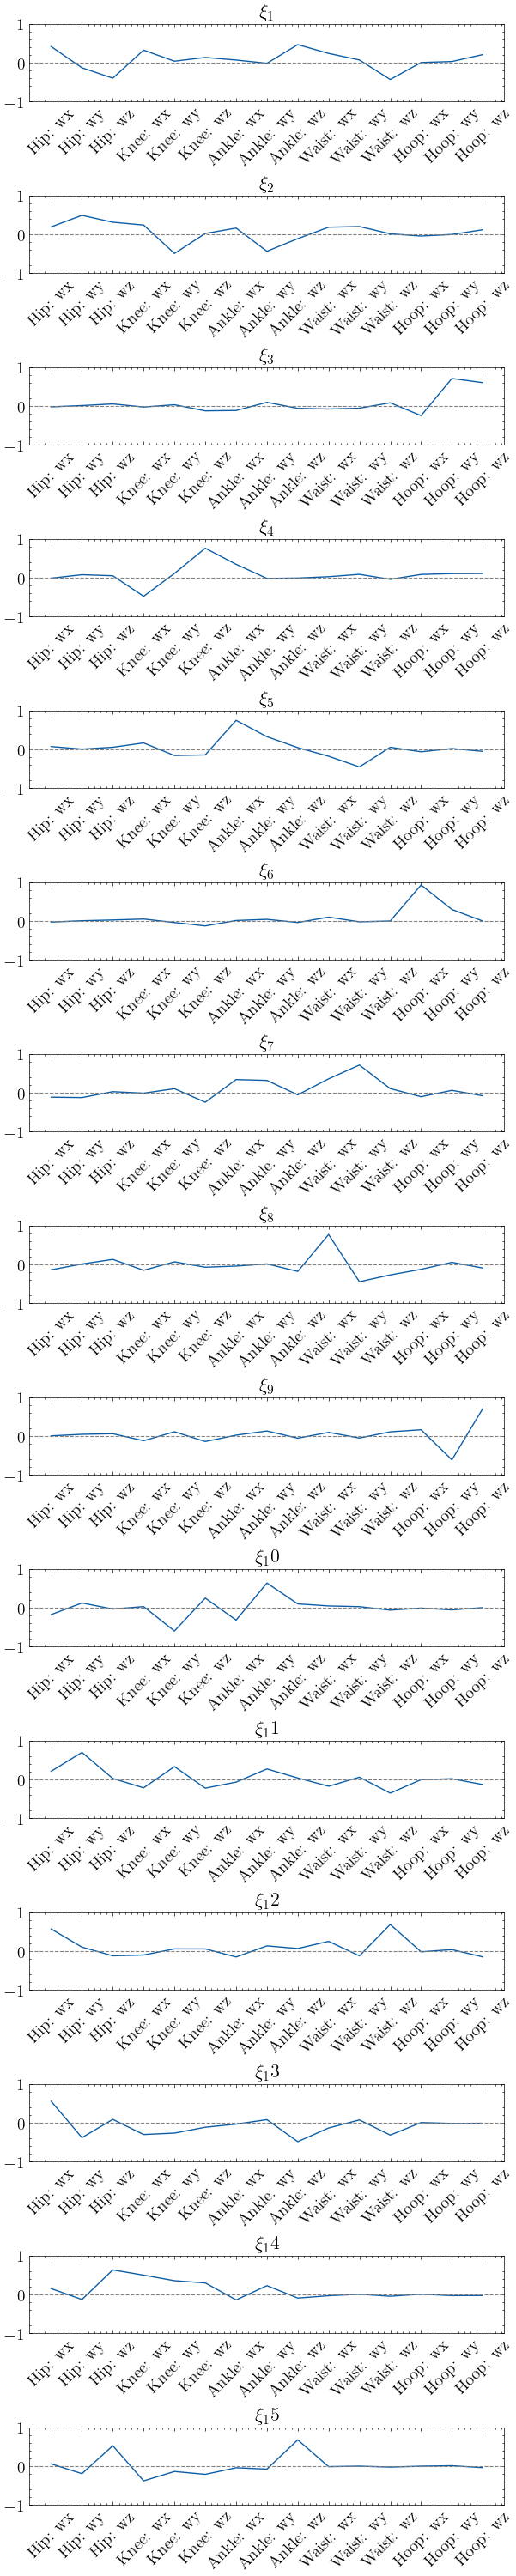

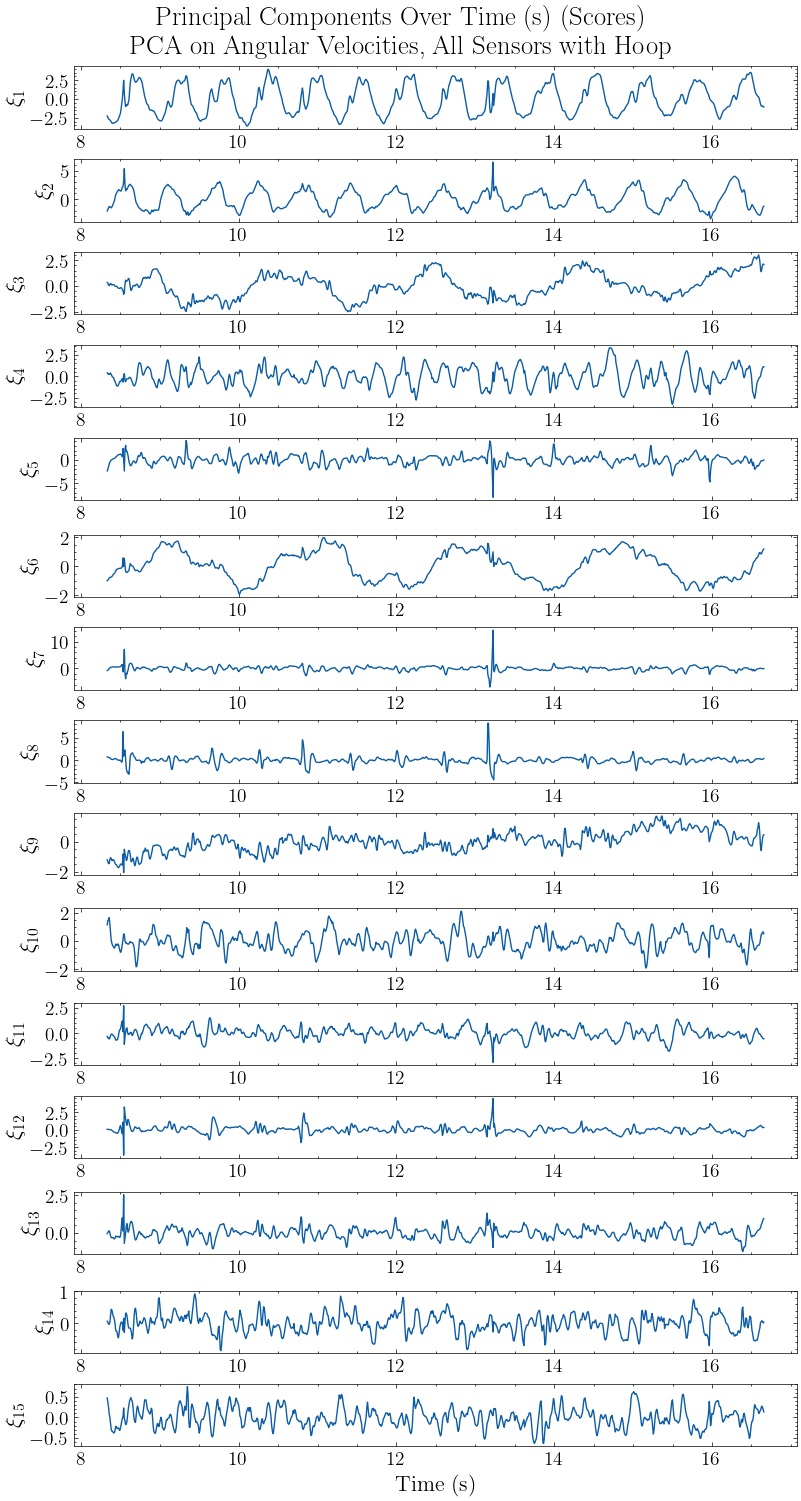

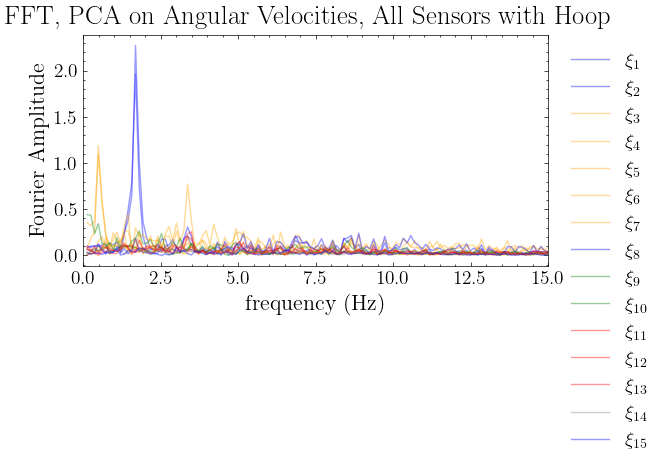

In [20]:
sensors_to_include = ["IB","IT","IL","OL","OR"]
quantities_to_include = ["wx","wy","wz"]
subtitle_veloc_all = "Angular Velocities, All Sensors with Hoop"

X_pca, eigenvalues, eigenvectors, explained_variance_ratio = perform_PCA(data_dict_veloc,active_slice,
                                                                         sensors_to_include,quantities_to_include,
                                                                         verbose=1) # set verbose=2 for PCA values and eigenvectors
plot_PCA_variance_ratios(explained_variance_ratio,subtitle_veloc_all)
plot_PCA_phase_portait(X_pca,subtitle_veloc_all)
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,15)
freq_psd  = [f"{1/estimate_period(X_pca[:,i], method='psd',  plot=False):.3f}" for i in range(X_pca.shape[1])]
# freq_srim = [f"{1/estimate_period(X_pca[:,i], method='srim', plot=False):.3f}" for i in range(X_pca.shape[1])]
print(f"{freq_psd =}")
# print(f"{freq_srim=}")

plot_PCA(X_pca,time,active_slice,subtitle="PCA on "+subtitle_veloc_all,separate=True)

# Plot the first four FFT
colors = ['b','b','orange','orange','orange','orange','orange','b','green','green','r','r','r','gray','b']
plot_PCA_FFT(X_pca,dt,"PCA on "+subtitle_veloc_all,n_modes=X_pca.shape[1],xlim=(0,15),colors=colors)

# PCA on FFT of angular velocities

## without hoop

X_FFT.shape=(499, 12)
Eigenvalues:
[9.14352084 1.12536089 0.71750575 0.33288527 0.21503284 0.13143601
 0.11523924 0.09716255 0.05311033 0.04595977 0.02985571 0.01702718]
Explained Variance Ratio:
[0.7604331  0.09359214 0.05967232 0.02768485 0.01788349 0.01093105
 0.00958403 0.00808065 0.00441699 0.00382231 0.00248299 0.00141609]


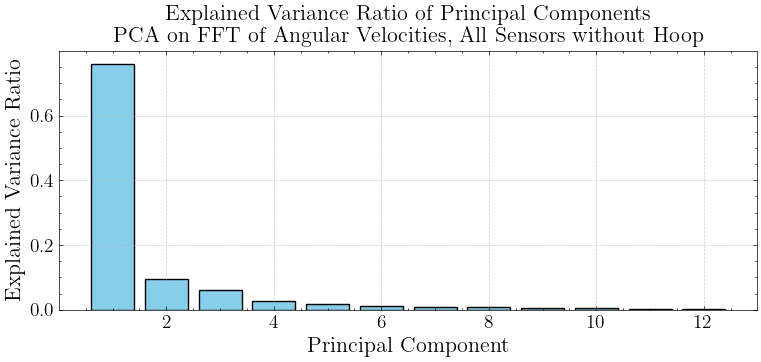

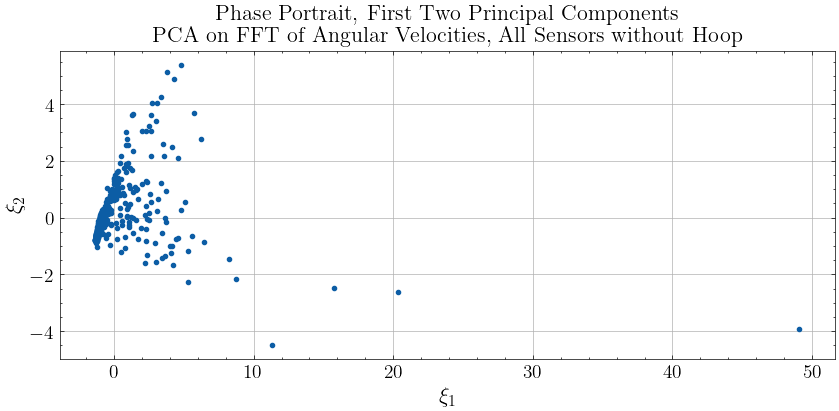

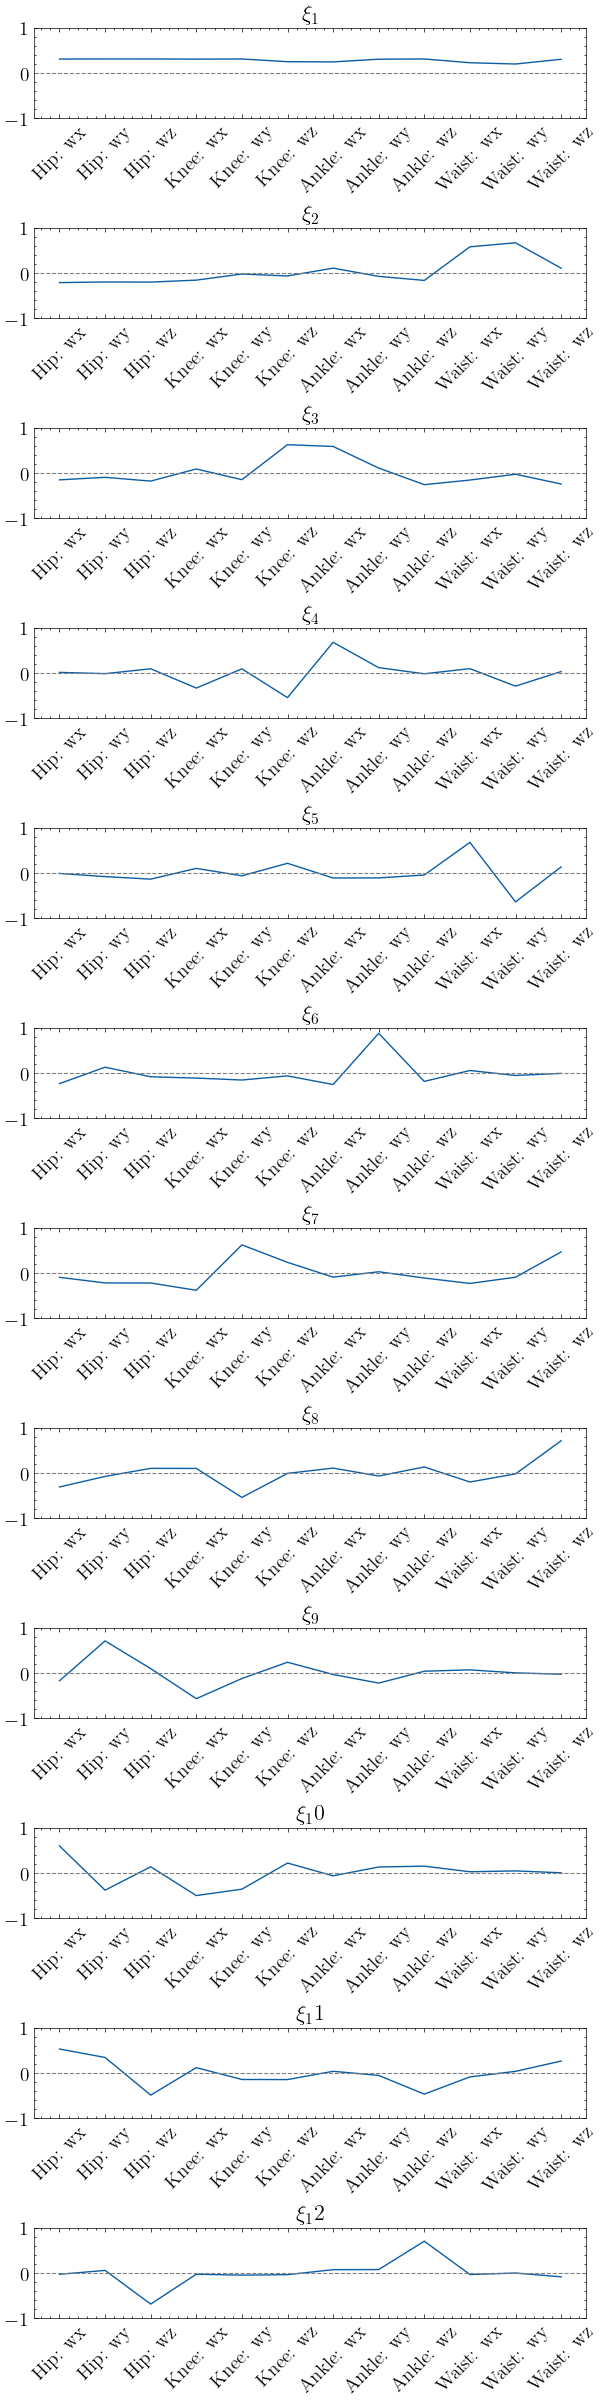

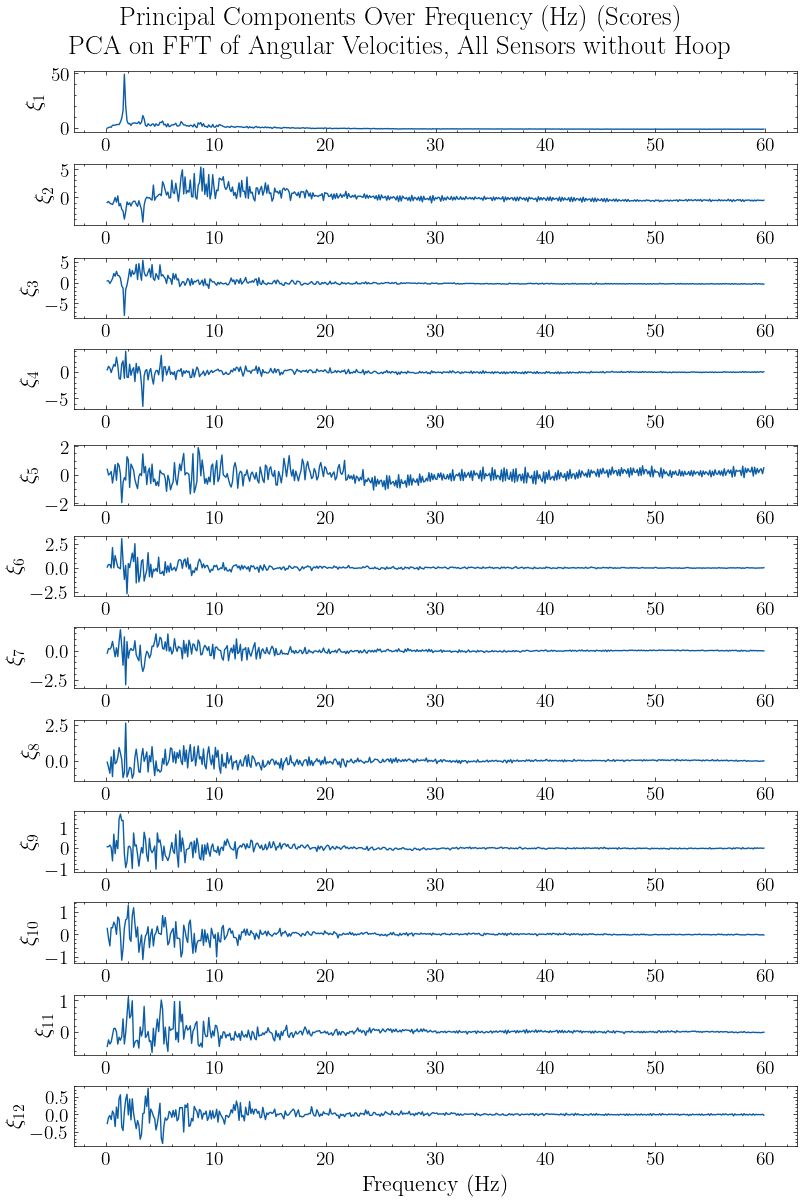

In [21]:
sensors_to_include = ["IB","IT","IL","OL"]
quantities_to_include = ["wx","wy","wz"]
X = np.vstack([data_dict_veloc[s][q][active_slice] for s in sensors_to_include for q in quantities_to_include]).T
X_FFT = np.vstack([fourier_spectrum(series=X[:,i],step=dt)[1] for i in range(X.shape[1])]).T
frequencies = fourier_spectrum(series=X[:,0],step=dt)[0] # fourier_spectrum gives (frequencies,amplitudes)
subtitle_veloc_fft = "FFT of Angular Velocities, All Sensors without Hoop"

print(f"{X_FFT.shape=}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_FFT)
pca = PCA(n_components=np.shape(X_FFT)[1])
X_pca = pca.fit_transform(X_scaled)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print("Eigenvalues:")
print(eigenvalues)
print("Explained Variance Ratio:")
print(explained_variance_ratio)

plot_PCA_variance_ratios(explained_variance_ratio,"PCA on "+subtitle_veloc_fft)
plot_PCA_phase_portait(X_pca,"PCA on "+subtitle_veloc_fft)
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,12)

plot_PCA(X_pca,frequencies,active_slice=None,subtitle="PCA on "+subtitle_veloc_fft,separate=True,domain_label=("Frequency (Hz)"))


## with hoop

X_FFT.shape=(499, 15)
Eigenvalues:
[9.52904877e+00 2.44388552e+00 1.09014228e+00 6.97799469e-01
 3.38839221e-01 2.31841610e-01 2.14839005e-01 1.26340080e-01
 1.12487959e-01 9.57426532e-02 5.14211158e-02 4.57230704e-02
 2.83247651e-02 1.70760153e-02 6.60894887e-03]
Explained Variance Ratio:
[6.33996832e-01 1.62599197e-01 7.25305081e-02 4.64267382e-02
 2.25440123e-02 1.54251331e-02 1.42938977e-02 8.40579290e-03
 7.48416883e-03 6.37005228e-03 3.42120450e-03 3.04209607e-03
 1.88453347e-03 1.13611966e-03 4.39713632e-04]


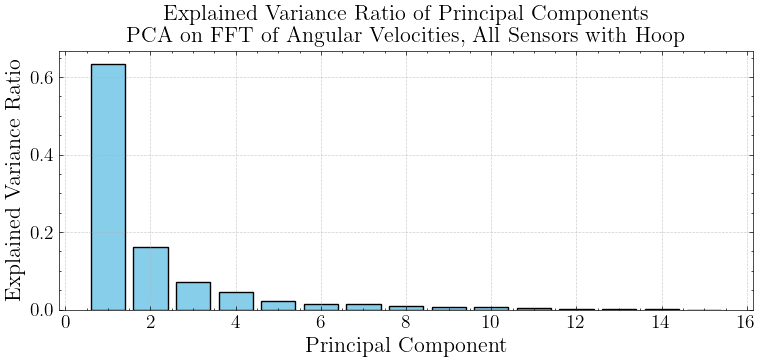

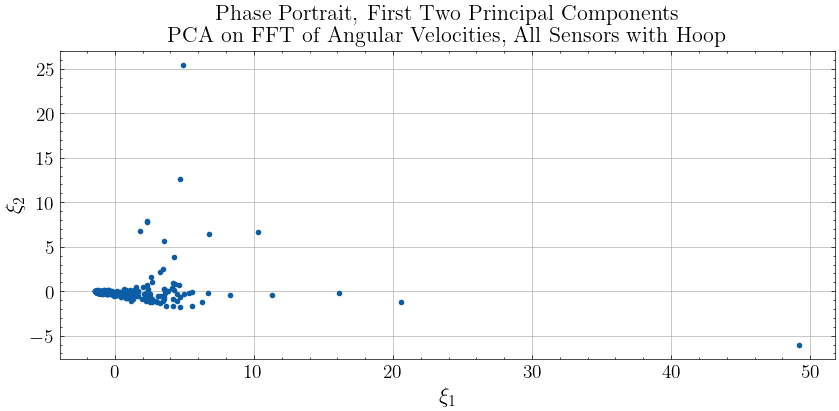

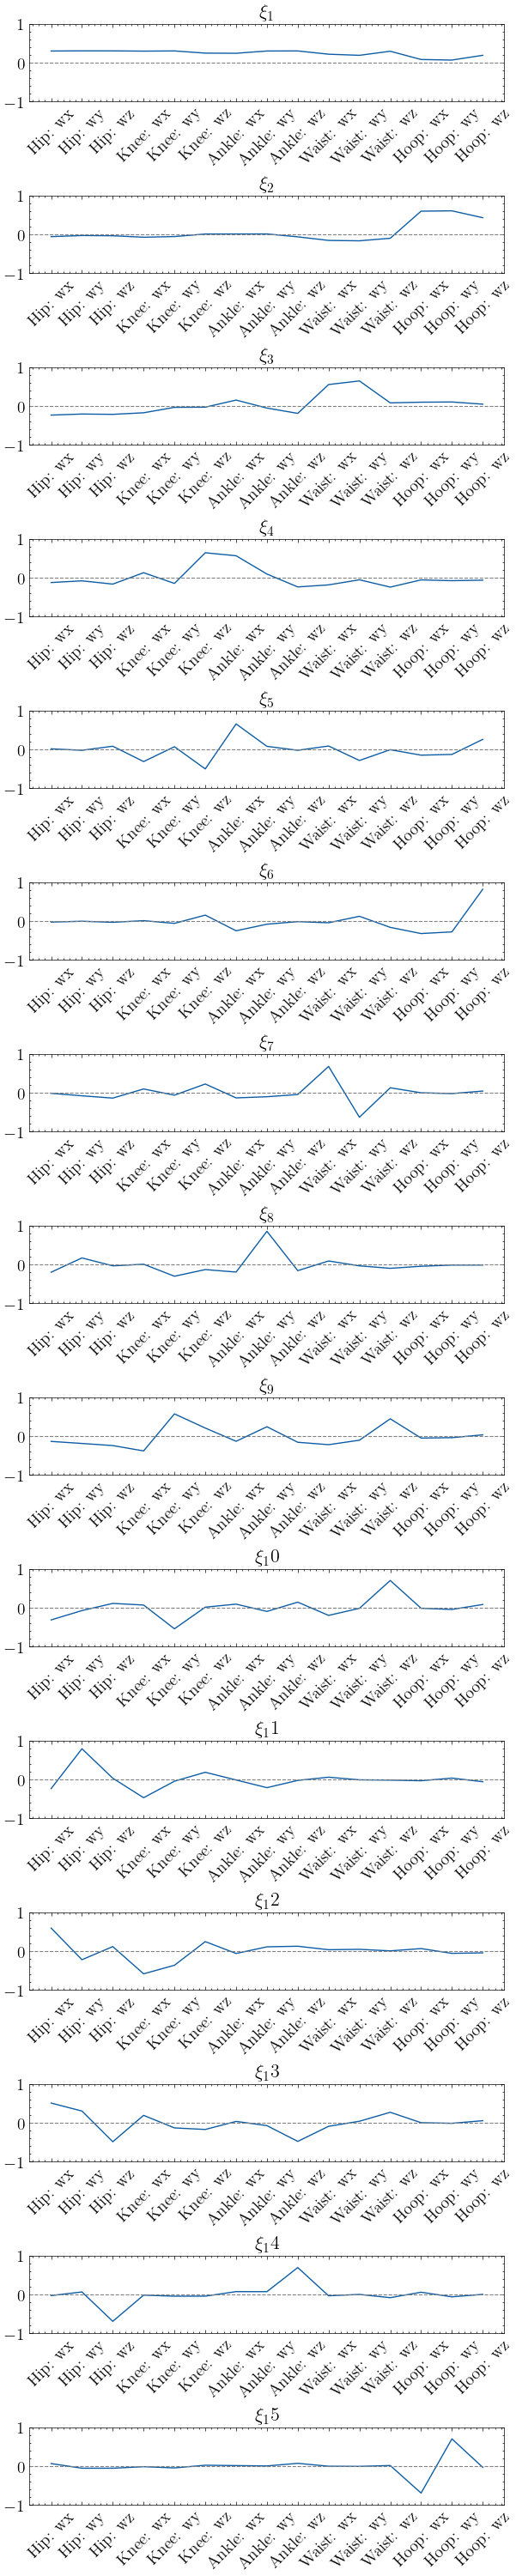

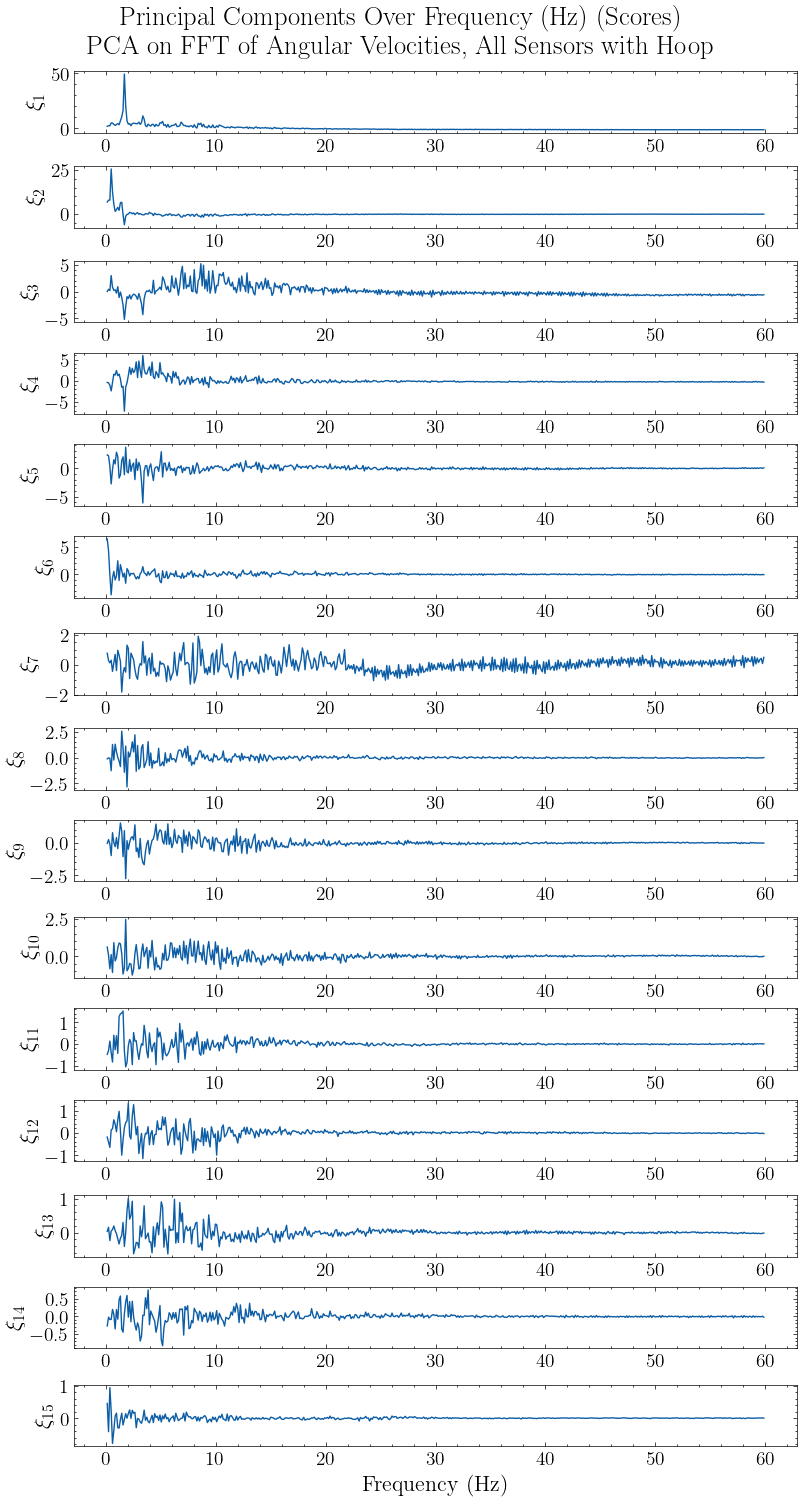

In [22]:
sensors_to_include = ["IB","IT","IL","OL","OR"]
quantities_to_include = ["wx","wy","wz"]
X = np.vstack([data_dict_veloc[s][q][active_slice] for s in sensors_to_include for q in quantities_to_include]).T
X_FFT = np.vstack([fourier_spectrum(series=X[:,i],step=dt)[1] for i in range(X.shape[1])]).T
frequencies = fourier_spectrum(series=X[:,0],step=dt)[0] # fourier_spectrum gives (frequencies,amplitudes)
subtitle_veloc_all_fft = "FFT of Angular Velocities, All Sensors with Hoop"

print(f"{X_FFT.shape=}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_FFT)
pca = PCA(n_components=np.shape(X_FFT)[1])
X_pca = pca.fit_transform(X_scaled)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print("Eigenvalues:")
print(eigenvalues)
print("Explained Variance Ratio:")
print(explained_variance_ratio)

plot_PCA_variance_ratios(explained_variance_ratio,"PCA on "+subtitle_veloc_all_fft)
plot_PCA_phase_portait(X_pca,"PCA on "+subtitle_veloc_all_fft)
plot_PCA_modes(eigenvectors,sensors_to_include,quantities_to_include,sensor_labels,15)

plot_PCA(X_pca,frequencies,active_slice=None,subtitle="PCA on "+subtitle_veloc_all_fft,separate=True,domain_label=("Frequency (Hz)"))
